<a href="https://colab.research.google.com/github/EndeavoringYoon/expecting-bitcoin-value/blob/main/bitcoin_val_expect_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyupbit

In [ ]:
%matplotlib inline
import numpy as np
import pyupbit
import torch
import time
from datetime import date
import datetime
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils import data
from IPython import display
from pandas import DataFrame

coin = 'KRW-BTC'
target_date = datetime.date(2022, 3, 18)
learning_rate = 0.0001
# batch size를 1일인 24로 설정
batch_size = 24
total_feature_number = 600
num_epochs = 100
weight_decay = 1e-7


## Data Preprocessing

In [ ]:
# 600일간의 1분동 데이터를 받아와서 시간당 종가를 예측.
# 1분동 데이터 60개를 reshape해서 feature 하나당 60분동안의 element 가짐
# 다음 1시간의 종가를 label로 가지게 설정


date2 = target_date.strftime('%Y%m%d')
target_fd = date2 + ' 00:01:00'
target_ld = date2 + ' 00:02:00'


feature_data = pyupbit.get_ohlcv(ticker=coin, interval="minute1", count=1440*total_feature_number, to=target_fd)
label_data = pyupbit.get_ohlcv(ticker=coin, interval="minute60", count=24*total_feature_number, to=target_ld)
    
rfeatures, rlabels = feature_data, label_data

In [ ]:
np.savetxt('rfeatures.csv', rfeatures, delimiter=',')
np.savetxt('rlabels.csv', rlabels, delimiter=',')

In [ ]:
#불러오기
#import io
#import pandas as pd
#rfeatures = np.array(pd.read_csv('rfeatures.csv'))
#rlabels = np.array(pd.read_csv('rlabels.csv'))
rdata = np.array(rfeatures)
features = np.reshape(rdata,(-1, 360))

ldata = np.array(rlabels)
labels = np.reshape(ldata[:,3], (-1,1)) # 종가만 추려서 [,1]로 만들기-> y값이 됨
#...했더니 값이 깨지는 거 같다...

In [ ]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        x = torch.FloatTensor(self.x_data[index])
        y = torch.FloatTensor(self.y_data[index])
        return x,y

    def __len__(self):
        return self.len

### Normalization시 주의사함

normalization에 사용하는 mean과 std는 train data의 mean과 std를 기반으로 해야 함, 즉 test와 application 때 사용하는 data도 모두 train feature mean과 train feature std를 기반으로 normalization을 해야 하고, test와 application 때 추론하는 output은 모두 train output mean과 train output std를 기반으로 normalization해야 함.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=1/6, shuffle = False)
#이거 train->test 순서로 나누니까 순서 신경 안써도 됨!
#러닝에는 tensor값만 받기 때문에 np.array에서 tensor로 형식 변경
trf_mean = train_features.mean(axis=0)
trf_std = train_features.std(axis =0)
train_features = (train_features - trf_mean) / trf_std # normalization
train_features = torch.tensor(train_features, dtype = torch.float32)


test_features = (test_features - trf_mean) / trf_std # normalization
test_features = torch.tensor(test_features, dtype = torch.float32)

trl_mean = train_labels.mean(axis=0)
trl_std = train_labels.std(axis = 0)
train_labels = (train_labels - trl_mean) / trl_std # normalization
train_labels = torch.tensor(train_labels, dtype = torch.float32)

#tl_mean = test_labels.mean(axis=0) # 나중에 test()에서 사용 예정
#tl_std = test_labels.std(axis=0)
test_labels = (test_labels - trl_mean) / trl_std # normalization
test_labels = torch.tensor(test_labels, dtype = torch.float32)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
ds_train = TensorDataset(train_features, train_labels)
ds_test = TensorDataset(test_features, test_labels)

loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

## 손실함수 설정

In [ ]:
loss = nn.MSELoss()

## 모델 구축

In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 360, 1, 60, 120
learning_rate = 0.0001
# batch size를 1일인 24로 설정
batch_size = 24
total_feature_number = 600
num_epochs = 500
weight_decay = 1e-7


model = nn.Sequential()
model.add_module('fc1', nn.Linear(num_inputs, num_hiddens1))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(num_hiddens1, num_hiddens2))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(num_hiddens2, num_outputs))

print(model)

Sequential(
  (fc1): Linear(in_features=360, out_features=60, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=60, out_features=120, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=120, out_features=1, bias=True)
)


In [ ]:
# 오차함수 선택
loss_fn = loss

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환
    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정

In [ ]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [ ]:
def test():
# len(expected_value)=100
# test_labels.shape=(2400, 1)
    i=0
    model.eval()  # 신경망을 추론 모드로 전환
    
    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:
            if i == 0:
              outputs = model(data)  # 데이터를 입력하고 출력을 계산
              expected_value = outputs
              i+=1
            else:
              outputs = model(data)
              expected_value = torch.cat((expected_value, outputs), 0)
        real_loss = test_labels.flatten() - expected_value.flatten() #y-net(X)
        real_loss = real_loss.reshape(1,-1)
        real_loss = real_loss*trl_std + trl_mean

        plot(np.arange(1, 2401), real_loss, xlabel='epoch', ylabel='real-expect', xlim=[1, 2401],legend=['test'])
           

In [ ]:
test_labels.shape

torch.Size([2400, 1])

In [ ]:
for epoch in range(num_epochs):
  train(epoch)

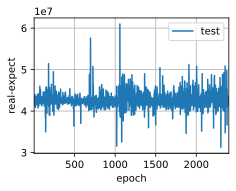

In [ ]:
test()

##Application

In [ ]:
from datetime import datetime
real_time = datetime.now()
real_time = real_time.strftime("%y%m%d %H")+":01:00"
realtime_data = pyupbit.get_ohlcv(coin, interval="minute1", count=1440, to=real_time)
print(realtime_data)
real_data = np.array(realtime_data).reshape((-1,360))
real_data = (real_data - trf_mean)/trf_std
real_data = torch.Tensor(real_data)

                           open        high         low       close    volume  \
2022-03-21 22:01:00  50397000.0  50408000.0  50389000.0  50399000.0  2.024646   
2022-03-21 22:02:00  50398000.0  50408000.0  50360000.0  50361000.0  3.064461   
2022-03-21 22:03:00  50361000.0  50399000.0  50361000.0  50399000.0  2.249259   
2022-03-21 22:04:00  50399000.0  50400000.0  50363000.0  50363000.0  3.273078   
2022-03-21 22:05:00  50363000.0  50371000.0  50360000.0  50361000.0  1.578224   
...                         ...         ...         ...         ...       ...   
2022-03-22 21:56:00  52195000.0  52210000.0  52170000.0  52202000.0  9.623758   
2022-03-22 21:57:00  52206000.0  52219000.0  52206000.0  52219000.0  4.143007   
2022-03-22 21:58:00  52219000.0  52222000.0  52211000.0  52222000.0  3.714048   
2022-03-22 21:59:00  52222000.0  52222000.0  52197000.0  52213000.0  4.244169   
2022-03-22 22:00:00  52216000.0  52230000.0  52197000.0  52227000.0  7.588745   

                           

In [ ]:
def application():
    model.eval()  # 신경망을 추론 모드로 전환
    
    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        outputs = model(real_data)  # 데이터를 입력하고 출력을 계산
        outputs = outputs*trl_std + trl_mean
        print(outputs)

In [ ]:
application()

tensor([[52380444.7471],
        [51366824.0071],
        [52506891.6196],
        [48040514.0345],
        [50273674.4409],
        [51916409.0260],
        [50252499.6862],
        [51921898.9706],
        [51792651.9849],
        [51047631.9869],
        [51246411.9625],
        [51509236.2884],
        [51861326.2124],
        [47732987.7387],
        [51014147.4362],
        [60556629.0447],
        [50431460.2637],
        [51014570.9443],
        [54700593.3350],
        [52286723.5039],
        [52847612.7318],
        [55838855.3280],
        [53312050.4267],
        [53981379.9266]], dtype=torch.float64)
